In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF
from auto_robot_design.optimization.saver import (ProblemSaver)
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import enhance_trajectory, convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L,get_preset_by_index
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
import pinocchio as pin



In [2]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

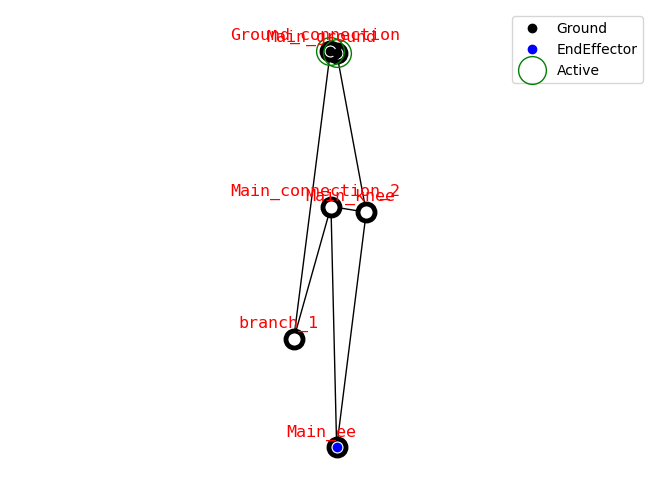

In [3]:
topology_index = 0
gm = get_preset_by_index_with_bounds(topology_index)
graph = gm.get_graph(np.array([-0.0063,  0.0023, -0.1615,  0.1506,  0.5051, -0.0372, -0.2922]))
draw_joint_point(graph)


#np.array([-0.0063,  0.0023, -0.1615,  0.1506,  0.5051, -0.0372, -0.2922])

In [4]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.33], 0.09, 0.24, 30, 60))


ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*enhance_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11, -0.32], step_height=0.07, step_width=0.22, n_points=50)))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*enhance_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11 + 0.025, -0.32], step_height=0.06, step_width=-2*(-0.11 + 0.025), n_points=50)))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*enhance_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11 + 2 * 0.025, -0.32], step_height=0.05, step_width=-2*(-0.11 + 2 * 0.025), n_points=50)))


central_vertical = convert_x_y_to_6d_traj_xz(
    *enhance_trajectory(get_vertical_trajectory(-0.32, 0.075, 0, 50)))

left_vertical = convert_x_y_to_6d_traj_xz(
    *enhance_trajectory(get_vertical_trajectory(-0.32, 0.065, -0.09, 50)))

right_vertical = convert_x_y_to_6d_traj_xz(
    *enhance_trajectory(get_vertical_trajectory(-0.32, 0.065, 0.09, 50)))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
# soft_constrain = PositioningConstrain(
#     error_calculator=error_calculator, points=[workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1,
                                                                                   ground_symmetric_step2,
                                                                                   ground_symmetric_step3,
                                                                                   central_vertical,
                                                                                   left_vertical,
                                                                                   right_vertical])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_trajectory(ground_symmetric_step2, 1)
reward_manager.add_trajectory(ground_symmetric_step3, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)

reward_manager.add_reward(heavy_lifting, 3, 1)
reward_manager.add_reward(heavy_lifting, 4, 1)
reward_manager.add_reward(heavy_lifting, 5, 1)

reward_manager.add_trajectory_aggregator([0, 1, 2], 'mean')
reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')

In [5]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)

In [8]:
pin.seed(5)
from auto_robot_design.pinokla.calc_criterion import (
    folow_traj_by_proximal_inv_k_2, iterate_over_q_space)


poses, q_array, constraint_errors, reach_array = folow_traj_by_proximal_inv_k_2(fixed_robot.model, fixed_robot.data, fixed_robot.constraint_models,
        fixed_robot.constraint_data, "EE", ground_symmetric_step1)

In [7]:
reach_array

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [8]:
res_dict_fixed = iterate_over_q_space(fixed_robot, q_array, 'EE')


In [9]:
ev = np.linalg.eigvals(res_dict_fixed['J_closed'][1][[0,2],:])
max(abs(ev))/min(abs(ev))

1.0

In [10]:
(-0.2+1)%1-1


-0.19999999999999996

In [11]:
(0.2+1)%1-1

-0.8

In [12]:
q_array


array([[-2.43334885e-01, -2.45532779e-01,  5.14354013e-01,
        -2.40436446e-02,  4.95214481e-02],
       [-1.84183573e-01,  6.12810216e+00, -5.89991816e+00,
        -4.39502026e-02,  8.79506231e-02],
       [ 6.07811393e+00,  1.24070728e+01, -1.84557074e+01,
        -6.11917994e-02,  9.06710807e-02],
       [-1.28237083e+01,  1.23680581e+01,  4.61081865e-01,
        -7.92097103e-02,  8.46413702e-02],
       [ 6.00143611e+00, -1.90591734e+01,  1.30461756e+01,
        -9.39585425e-02,  8.23967682e-02],
       [ 1.22814726e+01, -1.27694762e+01,  4.71982985e-01,
        -1.02814926e-01,  8.67942871e-02],
       [ 2.48254453e+01, -5.67645110e+01,  3.19075736e+01,
        -1.14342365e-01,  8.28502814e-02],
       [-1.28963801e+01, -1.07043446e+02,  1.19891363e+02,
        -1.25696607e-01,  7.72334082e-02],
       [-2.54621034e+01, -1.32170813e+02,  1.57584333e+02,
        -1.29659248e-01,  8.10762755e-02],
       [-2.54975204e+01, -1.32195349e+02,  1.57615699e+02,
        -1.44553548e-01

In [13]:
poses

array([[-2.19205908e-03,  4.81875962e-17, -3.98390426e-01],
       [-3.39497537e-03,  4.81376473e-17, -3.96975543e-01],
       [ 2.80340455e-03,  4.75051231e-17, -3.96875248e-01],
       [ 1.13899300e-02,  4.66550293e-17, -3.96953351e-01],
       [ 1.77790886e-02,  4.59974948e-17, -3.96803941e-01],
       [ 2.02415565e-02,  4.57165922e-17, -3.96518127e-01],
       [ 2.57546760e-02,  4.51443689e-17, -3.96348959e-01],
       [ 3.15990784e-02,  4.45339749e-17, -3.96138183e-01],
       [ 3.22474049e-02,  4.44453351e-17, -3.95940988e-01],
       [ 4.14273481e-02,  4.34850293e-17, -3.95597083e-01],
       [ 5.45991661e-02,  4.20567619e-17, -3.94685251e-01],
       [ 6.26342308e-02,  4.11382461e-17, -3.93736633e-01],
       [ 5.37884106e-02,  4.21230116e-17, -3.94561455e-01],
       [ 6.21188243e-02,  4.11927173e-17, -3.93760550e-01],
       [ 6.73453163e-02,  4.05885323e-17, -3.93087644e-01],
       [ 8.19839736e-02,  3.88694995e-17, -3.90980370e-01],
       [ 8.00481110e-02,  3.90973404e-17